In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import stats


# Load the CSV file 
url = "Price_Agriculture_commodities_Week.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataframe
print(df.head())



     State District    Market              Commodity      Variety Grade  \
0  Gujarat   Amreli  Damnagar  Bhindi(Ladies Finger)       Bhindi   FAQ   
1  Gujarat   Amreli  Damnagar                Brinjal        Other   FAQ   
2  Gujarat   Amreli  Damnagar                Cabbage      Cabbage   FAQ   
3  Gujarat   Amreli  Damnagar            Cauliflower  Cauliflower   FAQ   
4  Gujarat   Amreli  Damnagar      Coriander(Leaves)    Coriander   FAQ   

  Arrival_Date  Min Price  Max Price  Modal Price  
0   27-07-2023     4100.0     4500.0       4350.0  
1   27-07-2023     2200.0     3000.0       2450.0  
2   27-07-2023     2350.0     3000.0       2700.0  
3   27-07-2023     7000.0     7500.0       7250.0  
4   27-07-2023     8400.0     9000.0       8850.0  


In [3]:
# Display information about the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         23093 non-null  object 
 1   District      23093 non-null  object 
 2   Market        23093 non-null  object 
 3   Commodity     23093 non-null  object 
 4   Variety       23093 non-null  object 
 5   Grade         23093 non-null  object 
 6   Arrival_Date  23093 non-null  object 
 7   Min Price     23093 non-null  float64
 8   Max Price     23093 non-null  float64
 9   Modal Price   23093 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.8+ MB


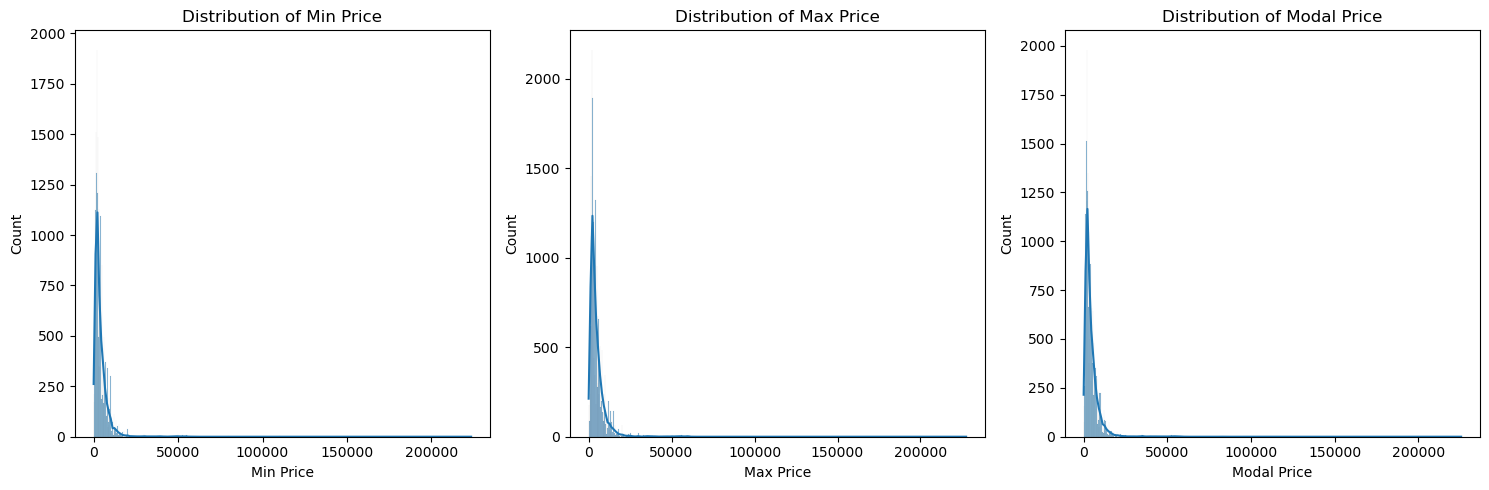

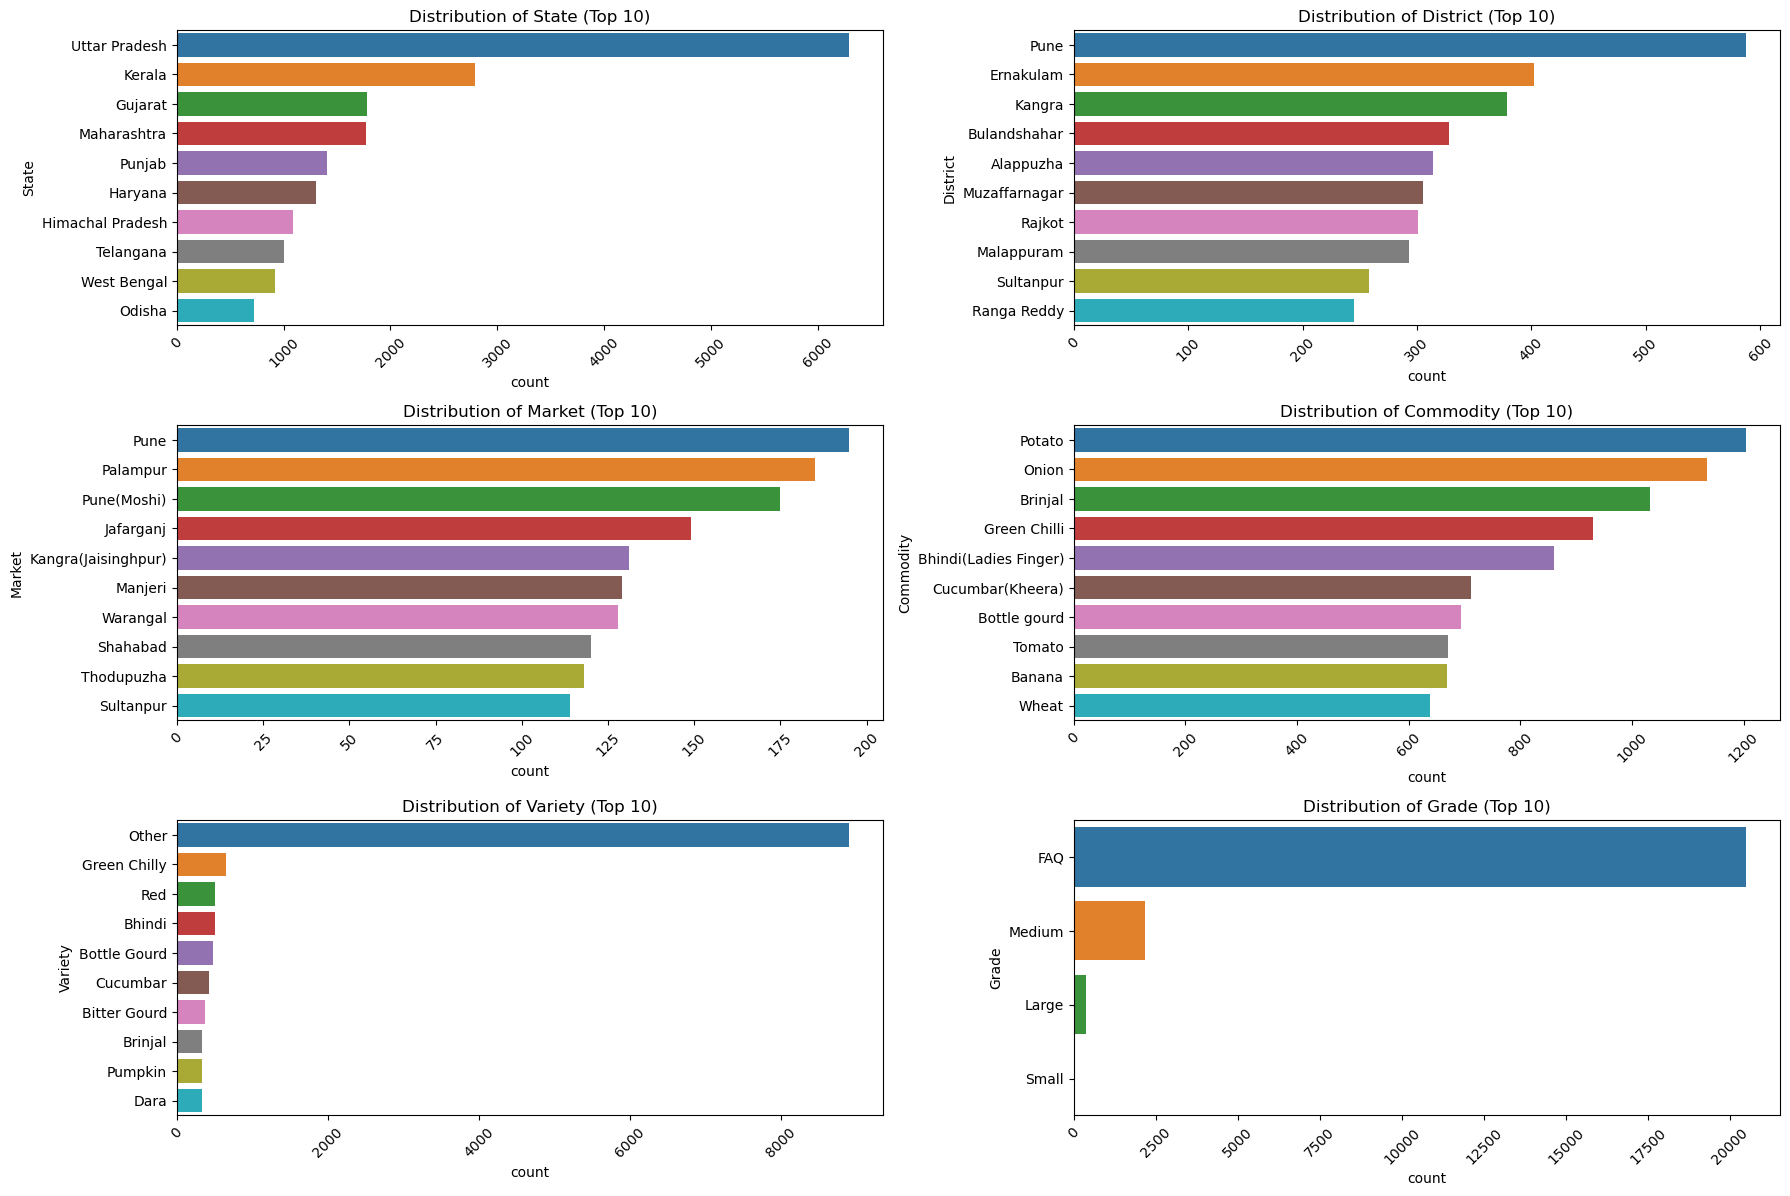

In [4]:

# Visualize price distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Min Price'], kde=True)
plt.title('Distribution of Min Price')

plt.subplot(1, 3, 2)
sns.histplot(df['Max Price'], kde=True)
plt.title('Distribution of Max Price')

plt.subplot(1, 3, 3)
sns.histplot(df['Modal Price'], kde=True)
plt.title('Distribution of Modal Price')

plt.tight_layout()
plt.show()

# Visualize the distribution of categorical variables (top 10 categories)
plt.figure(figsize=(18, 12))
variables_categorielles = ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade']

for i, var in enumerate(variables_categorielles, 1):
    plt.subplot(3, 2, i)
    top_categories = df[var].value_counts().nlargest(10).index
    sns.countplot(y=df[df[var].isin(top_categories)][var], order=top_categories)
    plt.title(f'Distribution of {var} (Top 10)')
    plt.tight_layout()
    plt.xticks(rotation=45)

plt.show()


In [5]:

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Convert 'Arrival_Date' to datetime
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], errors='coerce', dayfirst=True)

# Fill missing values
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Remove outliers using z-scores
z_scores = stats.zscore(df[numeric_columns])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_clean = df[filtered_entries]

# Display cleaned data
print("Cleaned data:\n", df_clean.head())


Missing values per column:
 State           0
District        0
Market          0
Commodity       0
Variety         0
Grade           0
Arrival_Date    0
Min Price       0
Max Price       0
Modal Price     0
dtype: int64
Cleaned data:
      State District    Market              Commodity      Variety Grade  \
0  Gujarat   Amreli  Damnagar  Bhindi(Ladies Finger)       Bhindi   FAQ   
1  Gujarat   Amreli  Damnagar                Brinjal        Other   FAQ   
2  Gujarat   Amreli  Damnagar                Cabbage      Cabbage   FAQ   
3  Gujarat   Amreli  Damnagar            Cauliflower  Cauliflower   FAQ   
4  Gujarat   Amreli  Damnagar      Coriander(Leaves)    Coriander   FAQ   

  Arrival_Date  Min Price  Max Price  Modal Price  
0   2023-07-27     4100.0     4500.0       4350.0  
1   2023-07-27     2200.0     3000.0       2450.0  
2   2023-07-27     2350.0     3000.0       2700.0  
3   2023-07-27     7000.0     7500.0       7250.0  
4   2023-07-27     8400.0     9000.0       8850.0  


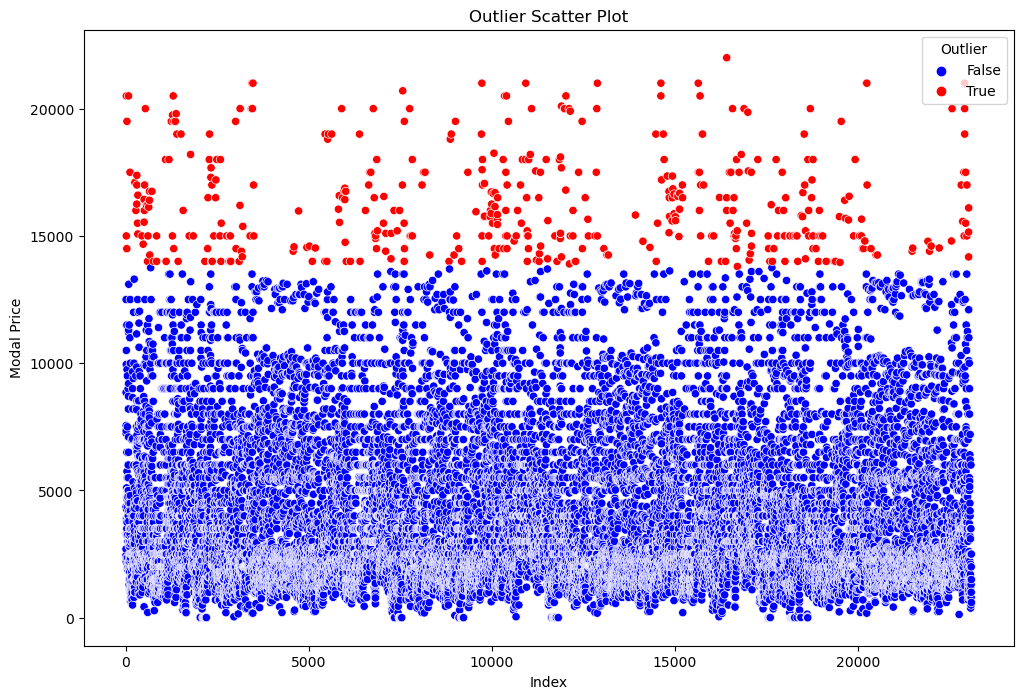

Outliers saved to 'valeurs_aberrantes.csv'
Non-outliers saved to 'donnees_non_aberrantes.csv'
Training set: 18227 samples
Validation set: 2278 samples
Test set: 2279 samples


In [6]:

# Encode categorical variables
df_encoded = pd.get_dummies(df_clean, columns=categorical_columns)

# Visualize outliers
z_scores = stats.zscore(df_encoded['Modal Price'])
abs_z_scores = abs(z_scores)
threshold = 3
df_encoded['is_outlier'] = abs_z_scores > threshold

plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_encoded.index, y=df_encoded['Modal Price'], hue=df_encoded['is_outlier'], palette={True: 'red', False: 'blue'}, marker='o')
plt.title('Outlier Scatter Plot')
plt.xlabel('Index')
plt.ylabel('Modal Price')
plt.legend(title='Outlier', loc='upper right')
plt.show()

# Create new datasets without outliers
Q1 = df['Modal Price'].quantile(0.25)
Q3 = df['Modal Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Modal Price'] < lower_bound) | (df['Modal Price'] > upper_bound)]
non_outliers = df[(df['Modal Price'] >= lower_bound) & (df['Modal Price'] <= upper_bound)]

outliers.to_csv('valeurs_aberrantes.csv', index=False)
non_outliers.to_csv('donnees_non_aberrantes.csv', index=False)

print(f"Outliers saved to 'valeurs_aberrantes.csv'")
print(f"Non-outliers saved to 'donnees_non_aberrantes.csv'")

# Display non-outlier data
non_outliers.head()

# Split the data into training, validation, and test sets
X = df_encoded.drop(['Modal Price'] + list(df_encoded.select_dtypes(include=['datetime']).columns), axis=1)
y = df_encoded['Modal Price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


In [7]:

# Normalize the data
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
print("Data normalized.")

# Display initial and transformed samples
initial_sample = df_encoded.head()
transformed_sample = df_clean.head()

print("Initial sample:\n", initial_sample)
print("Transformed sample:\n", transformed_sample)


Data normalized.
Initial sample:
   Arrival_Date  Min Price  Max Price  Modal Price  State_Andaman and Nicobar  \
0   2023-07-27     4100.0     4500.0       4350.0                          0   
1   2023-07-27     2200.0     3000.0       2450.0                          0   
2   2023-07-27     2350.0     3000.0       2700.0                          0   
3   2023-07-27     7000.0     7500.0       7250.0                          0   
4   2023-07-27     8400.0     9000.0       8850.0                          0   

   State_Andhra Pradesh  State_Bihar  State_Chandigarh  State_Chattisgarh  \
0                     0            0                 0                  0   
1                     0            0                 0                  0   
2                     0            0                 0                  0   
3                     0            0                 0                  0   
4                     0            0                 0                  0   

   State_Gujarat  ... 